In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Skip this cell if CSR2D/ is already added under PYHTONPATH 
import os, sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)  

In [3]:
# Ignore wanrings from singularities
import warnings
warnings.filterwarnings("ignore")

# Function definitions

In [4]:
import mpmath as mp
import numpy as np
import cupy as cp
import sys
import time

import matplotlib.pyplot as plt

from scipy.ndimage import convolve as conv
from scipy.signal import convolve2d, fftconvolve, oaconvolve
from cupyx.scipy.ndimage import convolve as cupy_conv

from csr2d.core import psi_s, psi_x, alpha, psi_x_mp
from csr2d.dist import lambda_p_Gauss
import concurrent.futures as cf

In [ ]:
def is_even(n):
    if n % 2 == 0:
        return -1
    else:
        return 0
a = np.array([[1, 2, 0, 0,2],[5, 3, 0, 4,5],[0, 0, 0, 7,3],[9, 3, 0, 0,2]])
(is_even(a.shape[0]),is_even(a.shape[1]))

In [9]:
t1 = time.time()
t2 = time.time()
print('step 1 takes:', t2-t1)

step 1 takes: 6.413459777832031e-05


In [5]:
def Ws(gamma, rho, sigmaz, sigmax, dz, dx, max_workers = 1, method='oa', xp=np, cupy_conv=None):
    """
    Apply 2D convolution to compute the longitudinal wake Ws on a grid 
    Also returns the zvec and xvec which define the grid
    
    Still needs to improve the convolution step
    """
    beta = (1-1/gamma**2)**(1/2)
    if method == 'cupy':
        pass
    elif method == 'oa':
        conv_method = oaconvolve
    elif method == 'fft':
        conv_method = fftconvolve
    elif method == '2d':
        conv_method = convolve2d
    else:
        print('Invalid convolution method specified!!')
        sys.exit("Exiting...")
    
    print('Here A')
    t1 = time.time()
    # Creating the grid of the z-derivative of the bunch distribution
    zvec = xp.arange(-5*sigmaz, 5*sigmaz, dz)
    xvec = xp.arange(-5*sigmax, 5*sigmax, dx)
    zm, xm = xp.meshgrid(zvec, xvec, indexing='ij')
    lambdap_grid = lambda_p_Gauss(zm,xm)
   
    #with cf.ProcessPoolExecutor(max_workers = max_workers) as executor:
    #    temp = executor.map(lambda_p_Gauss, zm, xm)
    #    lambdap_grid = np.array(list(temp))
        
    #lambdap_list = [[lambda_p_Gauss(i,j) for j in xvec] for i in zvec] 
    #lambdap_grid = xp.array(lambdap_list,dtype=float)
    
    print('Here B')
    t2 = time.time()
    # Creating the grid of the potential 
    zvec2 = xp.arange(-10*sigmaz, 10*sigmaz, dz)
    xvec2 = xp.arange(-10*sigmax, 10*sigmax, dx)
    zm2, xm2 = xp.meshgrid(zvec2, xvec2, indexing='ij')
    #psi_s_grid = psi_s(zm2,xm2,beta)
    
    beta_grid = beta*np.ones(zm2.shape)
    with cf.ProcessPoolExecutor(max_workers = max_workers) as executor:
        temp = executor.map(psi_s, zm2, xm2, beta_grid)
        psi_s_grid = np.array(list(temp))
    
    print('Here C')
    t3 = time.time()
    # Convolution
    if method == 'cupy':
        #origin = (is_even(psi_s_grid.shape[0]),is_even(psi_s_grid.shape[1]))
        #conv_s = cupy_conv(lambdap_grid, psi_s_grid, mode='constant',origin=origin)
        conv_s = cupy_conv(lambdap_grid, psi_s_grid, mode='constant')
    else:
        #conv_s = conv_method(lambdap_grid, psi_s_grid, mode='same', boundary='fill', fillvalue=0)
        conv_s = conv_method(lambdap_grid, psi_s_grid, mode='same')
        
    t4 = time.time()
    WsConv = (beta**2/rho)*(conv_s)*(dz*dx)
    
    print('step 1 takes:', t2-t1)
    print('step 2 takes:', t3-t2)
    print('step 3 takes:', t4-t3)
    print('In total it takes:', t4-t1)
   
    return zvec, xvec, WsConv

In [5]:
def haha(gamma, rho, sigmaz, sigmax, dz, dx, max_workers = 1, method='oa', xp=np, cupy_conv=None):
    beta = (1-1/gamma**2)**(1/2)
    
    t1 = time.time()
    # Creating the grid of the z-derivative of the bunch distribution
    zvec = xp.arange(-5*sigmaz, 5*sigmaz, dz)
    xvec = xp.arange(-5*sigmax, 5*sigmax, dx)
    zm, xm = xp.meshgrid(zvec, xvec, indexing='ij')
    lambdap_grid = lambda_p_Gauss(zm,xm)
    print(lambdap_grid[0][0])
    
    t2 = time.time()
    # Creating the grid of the potential 
    zvec2 = xp.arange(-10*sigmaz, 10*sigmaz, dz)
    xvec2 = xp.arange(-10*sigmax, 10*sigmax, dx)
    zm2, xm2 = xp.meshgrid(zvec2, xvec2, indexing='ij')
    psi_s_grid = psi_s(zm2,xm2,beta)
    #print('psi_s_grid is: ', psi_s_grid.__class__)
    print(psi_s_grid[0][0])
    t3 = time.time()

    # Convolution
    conv_s = cupy_conv(lambdap_grid, psi_s_grid, mode='constant')

    
    WsConv = (beta**2/rho)*(conv_s)*(dz*dx)
    t4 = time.time()    
    #t5 = time.time()
    #mempool.free_all_blocks()
    ##pinned_mempool.free_all_blocks()
    #t6 = time.time()
    
    print('step 1 takes:', t2-t1)
    print('step 2 takes:', t3-t2)
    print('step 3 takes:', t4-t3)
    #print('Cleaning memory takes:', t6-t5)
    
    return zm, xm, WsConv

In [6]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# Testing

In [7]:
gamma = 500
beta = (1-1/gamma**2)**(1/2)
rho = 1
sigmax = 10E-6
sigmaz = 10E-6

# Adjust the step size here
# Small steps might greatly increase computation time...
#dz = 0.1*sigmaz
#dx = 0.1*sigmax

N = 500
dz = 1.0E-4/N
dx = 1.0E-4/N

### Testing how to make psi_s_list faster...

In [44]:
%%time
zvec2 = np.arange(-10*sigmaz, 10*sigmaz, dz)
xvec2 = np.arange(-10*sigmax, 10*sigmax, dx)
zm2, xm2 = np.meshgrid(zvec2, xvec2, sparse=False, indexing='ij')

beta_grid = beta*np.ones(zm2.shape)

CPU times: user 11.3 ms, sys: 24.6 ms, total: 35.9 ms
Wall time: 34.7 ms


In [48]:
%%time
with cf.ProcessPoolExecutor(max_workers = 20) as executor:
    temp = executor.map(psi_s, zm2, xm2, beta_grid)
    result2 = np.array(list(temp))

CPU times: user 751 ms, sys: 405 ms, total: 1.16 s
Wall time: 1.55 s


In [ ]:
# Looping is SLOW, use vectorization in the future
psi_s_list = [[psi_s(i/2/rho,j,beta) for j in xvec2] for i in zvec2]  
psi_s_grid = np.array(psi_s_list,dtype=float)

### Trying with CP

In [9]:
zvec2 = cp.arange(-10*sigmaz, 10*sigmaz, dz)
xvec2 = cp.arange(-10*sigmax, 10*sigmax, dx)
zm, xm = cp.meshgrid(zvec2, xvec2, sparse=False, indexing='ij')
lambdap_grid = lambda_p_Gauss(zm,xm)
psi_s_grid = psi_s(zm,xm,beta)

In [6]:
cupy_conv(zvec2,xvec2, mode='constant');

NameError: name 'zvec2' is not defined

In [7]:
cupy_conv(lambdap_grid, psi_s_grid, mode='constant');

NameError: name 'lambdap_grid' is not defined

In [59]:
?psi_s

Signature: psi_s(z, x, beta)
Docstring:
2D longitudinal potential
Eq. (23) from Ref[1] with no constant factor (e*beta**2/2/rho**2).
Ref[1]: Y. Cai and Yuantao. Ding, PRAB 23, 014402 (2020)
File:      ~/CSR2D/csr2d/core.py
Type:      function


In [64]:
zvec2 = np.arange(-10*sigmaz, 10*sigmaz, dz)
xvec2 = np.arange(-10*sigmax, 10*sigmax, dx)
zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing='ij')
t1 = time.time()
psi_s_grid = psi_x(zm2,xm2,beta)
t2 = time.time()
print('Step 1 takes:', t2 - t1)

Step 1 takes: 3.1089351177215576


In [79]:
N = 1000
dz = 1.0E-4/N
dx = 1.0E-4/N

In [80]:
for i in range(5):
    t1 = time.time()
    # Creating the grid of the z-derivative of the bunch distribution
    zvec = np.arange(-5*sigmaz, 5*sigmaz, dz)
    xvec = np.arange(-5*sigmax, 5*sigmax, dx)
    zm, xm = np.meshgrid(zvec, xvec, indexing='ij')
    lambdap_grid = lambda_p_Gauss(zm,xm)
    print(lambdap_grid[0][0])
    
    t2 = time.time()
    
    # Creating the grid of the potential 
    zvec2 = np.arange(-10*sigmaz, 10*sigmaz, dz)
    xvec2 = np.arange(-10*sigmax, 10*sigmax, dx)
    zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing='ij')
    
    beta_grid = beta*np.ones(zm2.shape)
    with cf.ProcessPoolExecutor(max_workers = 20) as executor:
        temp = executor.map(psi_s, zm2, xm2, beta_grid)
        psi_x_grid = np.array(list(temp))
    print(psi_x_grid[0][0])
    
    t3 = time.time()
    
    conv_x = oaconvolve(lambdap_grid, psi_x_grid, mode='same')
    WxConv = (beta**2/rho)*(conv_s)*(dz*dx)
    print(WxConv[0][0])
    t4 = time.time()    
    
    
    print('Step 1 takes:', t2 - t1)
    print('Step 2 takes:', t3 - t2)
    print('Step 3 takes:', t4 - t3)

11051.674577458964
-0.5000825716839602
-0.49194053423700185
Step 1 takes: 0.05372023582458496
Step 2 takes: 2.0569686889648438
Step 3 takes: 0.683394193649292
11051.674577458964
-0.5000825716839602
-0.49194053423700185
Step 1 takes: 0.057626962661743164
Step 2 takes: 2.066011667251587
Step 3 takes: 0.6791727542877197
11051.674577458964
-0.5000825716839602
-0.49194053423700185
Step 1 takes: 0.05939483642578125
Step 2 takes: 2.019711971282959
Step 3 takes: 0.7099857330322266
11051.674577458964
-0.5000825716839602
-0.49194053423700185
Step 1 takes: 0.05705380439758301
Step 2 takes: 2.141183376312256
Step 3 takes: 0.7476351261138916
11051.674577458964
-0.5000825716839602
-0.49194053423700185
Step 1 takes: 0.06203794479370117
Step 2 takes: 2.1036875247955322
Step 3 takes: 0.735370397567749


## single run testing

In [55]:
%%time
zvec, xvec, WsConv = Ws(gamma, rho, sigmaz, sigmax, dz, dx, max_workers = 1)

Here A
Here B
Here C
step 1 takes: 0.2998943328857422
step 2 takes: 13.65669560432434
step 3 takes: 0.49344658851623535
In total it takes: 14.450036525726318
CPU times: user 1.3 s, sys: 514 ms, total: 1.82 s
Wall time: 14.5 s


In [8]:
%%time
zvec, xvec, WsConv = Ws(gamma, rho, sigmaz, sigmax, dz, dx, max_workers = 12)

Here A
Here B
Here C
step 1 takes: 0.018828153610229492
step 2 takes: 0.7156362533569336
step 3 takes: 0.1442582607269287
In total it takes: 0.8787226676940918
CPU times: user 476 ms, sys: 225 ms, total: 701 ms
Wall time: 882 ms


In [12]:
zvec = np.arange(-5*sigmaz, 5*sigmaz, dz)
xvec = np.arange(-5*sigmax, 5*sigmax, dx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')
lambdap_grid = lambda_p_Gauss(zm,xm)

In [13]:
lambdap_grid.shape

(500, 500)

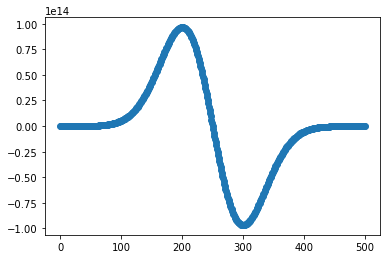

In [14]:
plt.scatter(np.arange(500),lambdap_grid[:,250])

In [16]:
zvec2 = np.arange(-10*sigmaz, 10*sigmaz, dz)
xvec2 = np.arange(-10*sigmax, 10*sigmax, dx)
zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing='ij')
    
beta_grid = beta*np.ones(zm2.shape)
with cf.ProcessPoolExecutor(max_workers = 20) as executor:
    temp = executor.map(psi_s, zm2, xm2, beta_grid)
    psi_s_grid = np.array(list(temp))


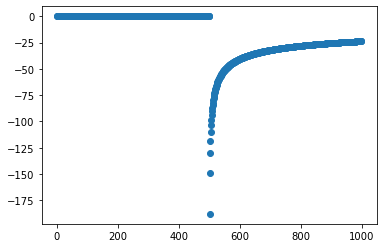

In [20]:
plt.scatter(np.arange(1000),psi_s_grid[:,500])

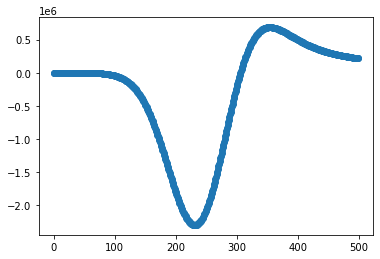

In [27]:
plt.scatter(np.arange(500),WsConv[:,250])

In [28]:
%%time
zvec, xvec, WsConv = Ws(gamma, rho, sigmaz, sigmax, dz, dx)

Here A
Here B
Here C
step 1 takes: 0.0421600341796875
step 2 takes: 10.286968469619751
step 3 takes: 0.5170655250549316
In total it takes: 10.84619402885437
CPU times: user 10 s, sys: 827 ms, total: 10.8 s
Wall time: 10.9 s


In [ ]:
%%time
zvec, xvec, WsConv = Ws(gamma, rho, sigmaz, sigmax, dz, dx, method='cupy', xp=cp, cupy_conv=cupy_conv)

In [ ]:
temp=abs(zvec)
zix_0 = np.where(temp == temp.min())[0][0] 
temp=abs(zvec-1*sigmaz)
zix_1sig = np.where(temp == temp.min())[0][0] 
temp=abs(zvec-2*sigmaz)
zix_2sig = np.where(temp == temp.min())[0][0] 

temp=abs(xvec)
xix_0 = np.where(temp == temp.min())[0][0] 
temp=abs(xvec-1*sigmax)
xix_1sig = np.where(temp == temp.min())[0][0] 
temp=abs(xvec-2*sigmax)
xix_2sig = np.where(temp == temp.min())[0][0] 

print(WsConv.shape)
print(zix_0)
print(zix_1sig)
print(zix_2sig)
print(WsConv[zix_0,xix_0])
print(WsConv[zix_1sig,xix_0])
print(WsConv[zix_2sig,xix_0])
print(WsConv[zix_0,xix_1sig])
print(WsConv[zix_0,xix_2sig])
WsConv.__class__

In [ ]:
%%time
zvec, xvec, WsConv = Ws(gamma, rho, sigmaz, sigmax, dz, dx, 'oa')

In [ ]:
print(WsConv[zix_min,xix_min])
WsConv.__class__

In [ ]:
%%time 
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'fft')

In [ ]:
print(WsConv[zix_min,xix_min])
WsConv.__class__

## timing test

In [ ]:
%%timeit -n 3 -r 3
Ws(gamma, rho, sigmaz, sigmax, dz, dx, method='cupy', xp=cp, cupy_conv=cupy_conv)

In [ ]:
%%timeit -n 3 -r 3
zvec,xvec, WsConv = Ws(gamma,rho,sigmaz,sigmax,dz,dx,'oa')

# I/O

In [ ]:
# Find index where zvec returns one sigma_z
temp=abs(zvec-1*sigmaz)
zix_1sig = np.where(temp == temp.min())[0][0] 
print(zix_1sig)
print(zvec[zix_1sig])

In [ ]:
print(zvec.shape[0])
print(xvec.shape[0])

In [ ]:
size = 1000

# cp doesn't have savetxt function, so load it to npy first hten use np to write
cp.save('temp.npy',WsConv)
dat = np.load('temp.npy')
np.savetxt('WsConv_'+str(size)+'.txt',dat)

# Below is Scratch for now

In [ ]:
zvec_abs=abs(zvec)
zix_min = np.where(abs(zvec_abs) == zvec_abs.min())[0][0] # find the index for which xvec[index] is closest to zero
xvec_abs=abs(xvec)
xix_min = np.where(abs(xvec_abs) == xvec_abs.min())[0][0]

WsConv[zix_min,xix_min] # returns Ws(~0,~0)

In [ ]:
WsConv.__class__

In [ ]:
cp.save('t1.npy',WsConv)

In [ ]:
dat = np.load('t1.npy')
np.savetxt('text.txt',dat)

In [ ]:
np.save('test',WsConv)
np.load('test.npy');

## Vectorize from Chris

In [ ]:
@np.vectorize
def mf(a,b):
    return lambda_p_Gauss(a,b)
vf = np.vectorize(mf)
vf([[0.00001,0.00002],[0.00003,0.00004]] , [[0.00001,0.00002],[0.0003,0.00004]])

In [ ]:
zvec_abs=abs(zvec)
zix_min = np.where(abs(zvec_abs) == zvec_abs.min())[0][0] # find the index for which xvec[index] is closest to zero
xvec_abs=abs(xvec)
xix_min = np.where(abs(xvec_abs) == xvec_abs.min())[0][0]

plt.plot(zvec/sigmaz, WsConv[:,int(xix_min)]/1e6, '-', color='black', label=f"x = {xvec[xix_min]/sigmax:5.2f} $\sigma_x$");
plt.legend(loc='upper left')
plt.xlabel('z/$\sigma_z$')
plt.ylabel('Ws$(10^6 m^{-2})$')

In [ ]:
%timeit -n 3 -r 4 ndimage.convolve(a, k, mode='constant', cval=0.0)
%timeit -n 3 -r 4 signal.convolve2d(a, k, mode='same')
%timeit -n 3 -r 4 fftconvolve(a, k, mode='same')
%timeit -n 3 -r 4 oaconvolve(a, k, mode='same')

a = cp.random.randint(5, size=(N, N))
k = cp.random.randint(5, size=(2*N, 2*N))
%timeit -n 3 -r 4 filters.convolve(a, k, mode='constant', cval=0.0)

In [ ]:
from scipy.ndimage import convolve as conv
from scipy.signal import convolve2d, fftconvolve, oaconvolve
a = np.array([[1, 2, 0, 0],[5, 3, 0, 4],[0, 0, 0, 7],[9, 3, 0, 0]])
k = np.array([[1,1,1,1,1],[1,1,1,1,0],[1,1,1,0,0],[1,1,0,0,0],[1,0,0,0,0]])
print(conv(a, k, mode='constant', cval=0.0))

In [ ]:
a = cp.array([[1, 2, 0, 0],[5, 3, 0, 4],[0, 0, 0, 7],[9, 3, 0, 0]])
k = cp.array([[1,1,1,1,1],[1,1,1,1,0],[1,1,1,0,0],[1,1,0,0,0],[1,0,0,0,0]])
print(cupy_conv(a, k, mode='constant', cval=0.0))